# Import the essentials

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting

# Import Image Libraries - Pillow and OpenCV
from PIL import Image
import cv2

# Import PyTorch and useful fuctions
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset,random_split
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch.optim as optim
import torchvision.models as models # Pre-Trained models

# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score

import time
from tqdm import tqdm_notebook

import os
print(os.listdir("../input"))
base_dir = "../input/aptos2019-blindness-detection/"

['aptos2019-blindness-detection', 'pretrained-model-weights-pytorch']


# Loading Data + EDA

In [20]:
train_csv = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_csv = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [21]:
print('Train Size = {}'.format(len(train_csv)))
print('Public Test Size = {}'.format(len(test_csv)))

Train Size = 3662
Public Test Size = 1928


Displaying the contents of the training and the test dataset

In [22]:
train_csv.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [23]:
test_csv.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


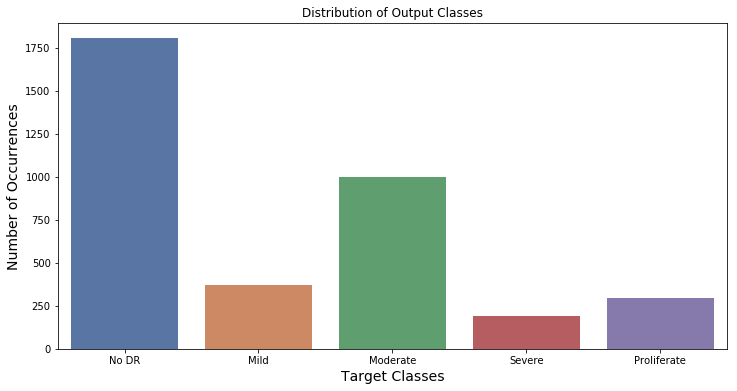

In [24]:
counts = train_csv['diagnosis'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i)

plt.figure(figsize=(12,6))
sns.barplot(counts.index, counts.values, alpha=1, palette='deep')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xlabel('Target Classes', fontsize=14)
plt.show()

# Visualizing Training Data

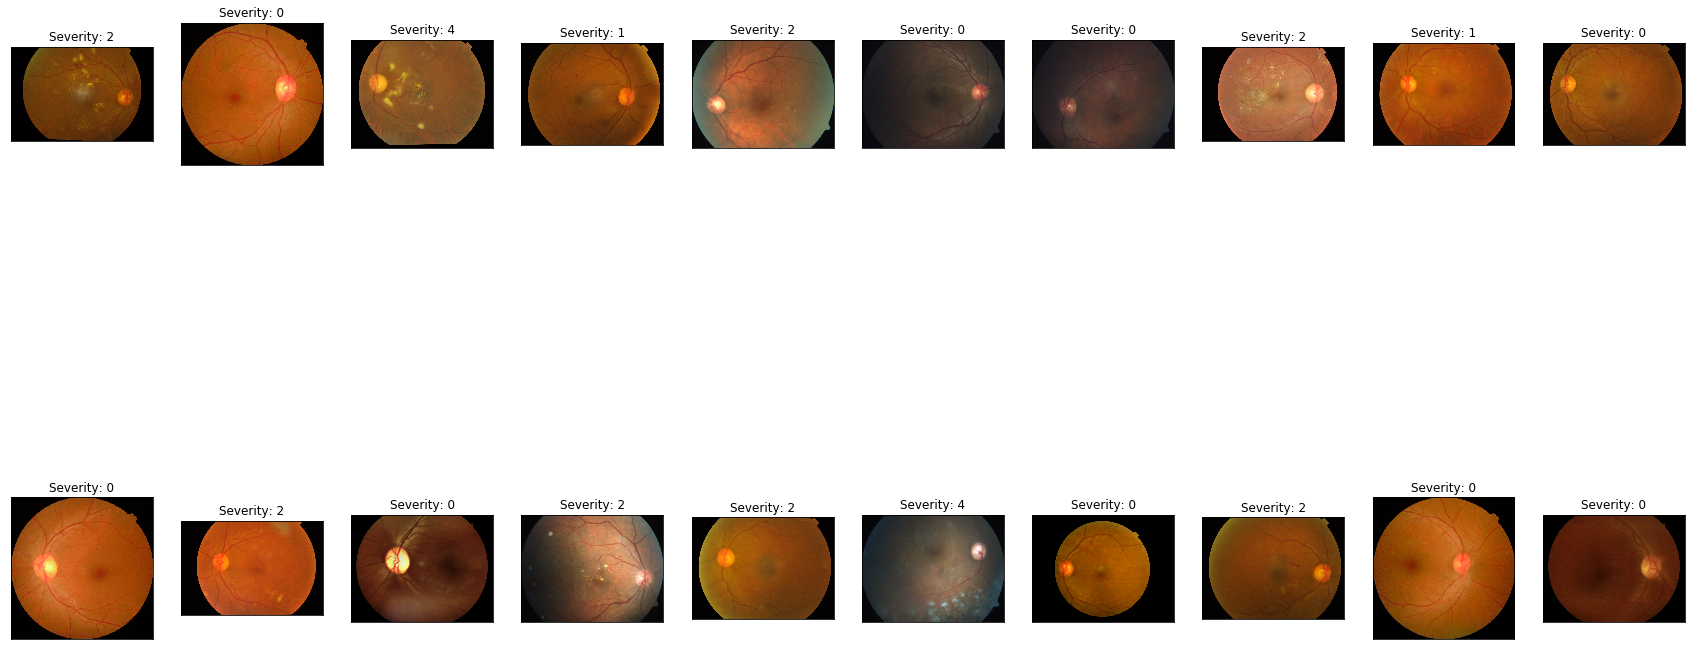

In [25]:
fig = plt.figure(figsize=(30, 16))
# display 20 images
train_imgs = os.listdir(base_dir+"/train_images")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/train_images/" + img)
    plt.imshow(im)
    lab = train_csv.loc[train_csv['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

# Visualizing Test Set

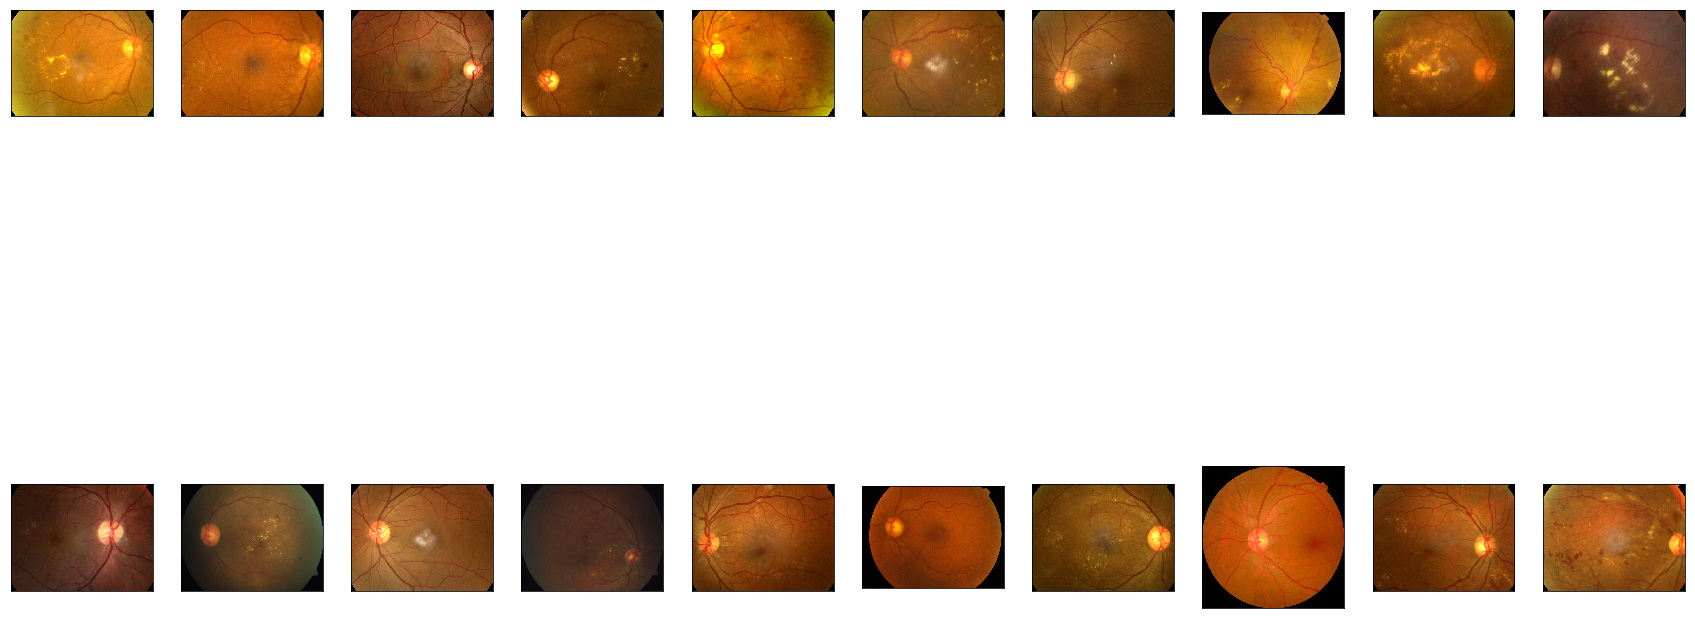

In [26]:
fig = plt.figure(figsize=(30, 16))
# display 20 images
test_imgs = os.listdir(base_dir+"/test_images")
for idx, img in enumerate(np.random.choice(test_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/test_images/" + img)
    plt.imshow(im)

# Data Processing

In [27]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '../input/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [28]:
transforms = transforms.Compose([
    transforms.ToPILImage(mode='RGB'),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [29]:
train_path = "../input/aptos2019-blindness-detection/train_images/"
test_path = "../input/aptos2019-blindness-detection/test_images/"

In [30]:
 train_data = CreateDataset(df_data=train_csv, data_dir=train_path, transform=transforms)

In [31]:
# Set Batch Size
batch_size = 32

# Percentage of training set to use as validation
valid_size = 0.15

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

# Define Model Architecture

In [32]:
model = models.resnet152(pretrained=False)
model.load_state_dict(torch.load("../input/pretrained-model-weights-pytorch/resnet152-b121ed2d.pth"))
# for param in model.parameters():
#     param.requires_grad = False
model.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
model.fc = nn.Sequential(
                nn.Linear(in_features=2048, out_features=1024, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=1024, out_features=512, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=512, out_features=256, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=256, out_features=128, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=128, out_features=32, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=32, out_features=1, bias=True), 
            )

In [33]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    model.cuda()

CUDA is available!  Training on GPU ...


In [34]:
# Trainable Parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
60935169


# Training (Fine Tuning) and Validation

In [35]:
# specify loss function (categorical cross-entropy loss)
criterion = nn.SmoothL1Loss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00015)

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [37]:
# number of epochs to train the model
n_epochs = 7

valid_loss_min = np.Inf

# keeping track of losses as it happen
train_losses = []
valid_losses = []
val_kappa = []
test_accuracies = []
valid_accuracies = []
kappa_epoch = []
batch = 0

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in tqdm_notebook(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in tqdm_notebook(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1)
        with torch.set_grad_enabled(True):
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        #output = output.cohen_kappa_score_kappa_score)
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_kappa.append(cohen_kappa_score(y_actual, y_pred.round()))        
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_kappa = np.mean(val_kappa)
    kappa_epoch.append(np.mean(val_kappa))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} | Training Loss: {:.6f} | Val. Loss: {:.6f} | Val. Kappa Score: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_kappa))
    
    ##################
    # Early Stopping #
    ##################
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss


Epoch: 1 | Training Loss: 0.248553 | Val. Loss: 0.212275 | Val. Kappa Score: 0.5396
Validation loss decreased (inf --> 0.212275).  Saving model ...



Epoch: 2 | Training Loss: 0.145449 | Val. Loss: 0.144852 | Val. Kappa Score: 0.6082
Validation loss decreased (0.212275 --> 0.144852).  Saving model ...



Epoch: 3 | Training Loss: 0.128364 | Val. Loss: 0.150283 | Val. Kappa Score: 0.6292



Epoch: 4 | Training Loss: 0.123767 | Val. Loss: 0.128994 | Val. Kappa Score: 0.6430
Validation loss decreased (0.144852 --> 0.128994).  Saving model ...



Epoch: 5 | Training Loss: 0.092197 | Val. Loss: 0.164010 | Val. Kappa Score: 0.6316



Epoch: 6 | Training Loss: 0.093089 | Val. Loss: 0.141012 | Val. Kappa Score: 0.6294



Epoch: 7 | Training Loss: 0.080000 | Val. Loss: 0.131636 | Val. Kappa Score: 0.6300


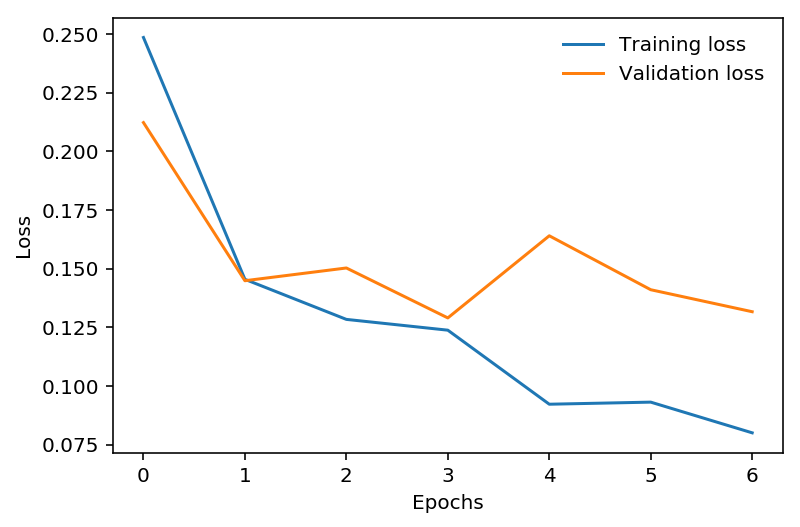

In [38]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

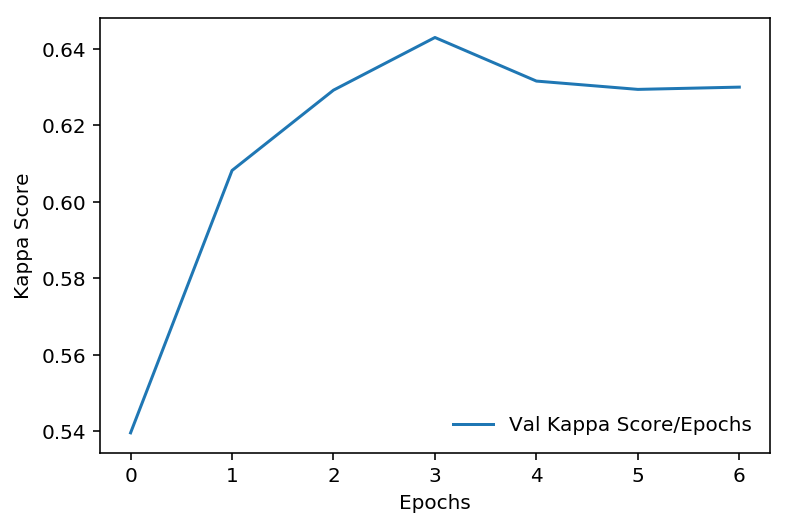

In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(kappa_epoch, label='Val Kappa Score/Epochs')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("Kappa Score")
plt.legend(frameon=False)

In [40]:
model.load_state_dict(torch.load('best_model.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

# Inference

In [41]:
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),
    #torchvision.transforms.ColorJitter(brightness=2, contrast=2),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [42]:
test_csv['diagnosis'] = -1

In [43]:
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [44]:
 def round_off_preds(preds, coef=[0.5, 1.5, 2.5, 3.5]):
    for i, pred in enumerate(preds):
            if pred < coef[0]:
                preds[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                preds[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                preds[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                preds[i] = 3
            else:
                preds[i] = 4
    return preds

In [45]:
def predict(testloader):
    '''Function used to make predictions on the test set'''
    model.eval()
    preds = []
    for batch_i, (data, target) in enumerate(testloader):
        data, target = data.cuda(), target.cuda()
        output = model(data)
        pr = output.detach().cpu().numpy()
        for i in pr:
            preds.append(i.item())
            
    return preds

### TTA (Test Time Augmentation)

In [46]:
preds1 = np.array(predict(testloader=test_loader))

In [47]:
preds2 = np.array(predict(testloader=test_loader))

In [48]:
preds3 = np.array(predict(testloader=test_loader))

In [49]:
preds4 = np.array(predict(testloader=test_loader))

In [50]:
preds5 = np.array(predict(testloader=test_loader))

In [51]:
preds6 = np.array(predict(testloader=test_loader))

In [52]:
preds7 = np.array(predict(testloader=test_loader))

In [53]:
preds8 = np.array(predict(testloader=test_loader))

In [54]:
preds = (preds1 + preds2 + preds3 + preds4 + 
         preds5 + preds6 + preds7 + preds8)/8.0

In [55]:
preds = round_off_preds(preds)

# Generating Submission File

In [56]:
sample_sub = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [57]:
sample_sub.diagnosis = preds
sample_sub.diagnosis = sample_sub['diagnosis'].astype(int)

In [58]:
sample_sub.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,2


In [59]:
sample_sub.to_csv('submission.csv', index=False)

In [ ]:
!pip install jovian --upgrade

     |████████████████████████████████| 71kB 2.5MB/s eta 0:00:011
  Stored in directory: /root/.cache/pip/wheels/2a/80/9b/015026567c29fdffe31d91edbe7ba1b17728db79194fca1f21
Successfully built uuid


In [ ]:
import jovian

In [ ]:
jovian.commit(project='course-project-version3')